### Colab stuff

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install gensim==3.8.1
!pip install sacrebleu

     |████████████████████████████████| 24.2MB 132kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 17.1MB 16.4MB/s 


In [0]:
import os
os.chdir(os.path.join('drive', 'My Drive', 'project2'))
os.getcwd()

'/content/drive/My Drive/project2'

### imports

In [0]:
import tensorflow as tf
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import sacrebleu

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from utils.data import postprocessing
from utils.data import checkout_data

from models.transformer import Transformer
from models.transformer.utils import create_masks
from utils.dataloader import encoder_preprocess, decoder_preprocess

## Set seed

In [0]:
tf.random.set_seed(
    123456
)

### Dataloader

In [0]:
encoder_dataset, encoder_v2id, encoder_id2v = encoder_preprocess(data="data/aligned_unformated_en")
decoder_dataset, decoder_v2id, decoder_id2v = decoder_preprocess(data="data/aligned_formated_fr")

100%|██████████| 11000/11000 [00:12<00:00, 875.07it/s] 


In [0]:
(
    input_tensor_train,
    input_tensor_valid,
    target_tensor_train,
    target_tensor_valid
) = train_test_split(encoder_dataset, decoder_dataset, test_size=0.2, shuffle=False)

In [0]:
BUFFER_SIZE = len(input_tensor_train)
batch_size = 32
dataset_train = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).batch(batch_size, drop_remainder=False)
dataset_valid = tf.data.Dataset.from_tensor_slices(
    (input_tensor_valid, target_tensor_valid)).batch(batch_size, drop_remainder=False)


#### View data sample

In [0]:
for i,j in dataset_train:
  for z in i[10].numpy():
    print(encoder_id2v[z], end = ' ')
  print("\n")
  for z in j[10].numpy():
    print(decoder_id2v[z], end = ' ')
  print("\n")
  break

for i,j in dataset_valid:
  for z in i[0].numpy():
    print(encoder_id2v[z], end = ' ')
  print("\n")
  for z in j[0].numpy():
    print(decoder_id2v[z], end = ' ')
  print("\n")
  break


<SOS> regulation applying a scheme of generalised tariff preferences vote <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

<SOS> <CAP> règlement appliquant un schéma de préférences tarifaires généralisées ( vote ) <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

# Transformer model for language understanding

## Set hyperparameters

In [0]:
num_layers = 2
d_model = 128
dff = 512
num_heads = 16

input_vocab_size = len(encoder_v2id) + 1
target_vocab_size = len(decoder_v2id) + 1
dropout_rate = 0.3

## Optimizer

In [0]:
from models.transformer.utils import CustomSchedule

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

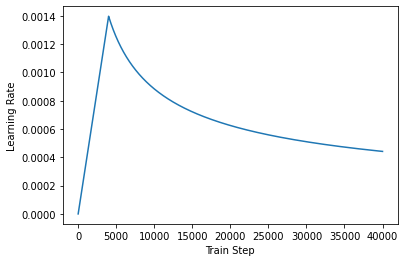

In [0]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='valid_accuracy')

## Training and checkpointing

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [0]:
checkpoint_path = "./checkpoints/train/w2w/unformated_en_2_formated_fr"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

In [0]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  train_loss(loss)
  train_accuracy(tar_real, predictions)

@tf.function(input_signature=train_step_signature)
def valid_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  predictions, _ = transformer(inp, tar_inp, 
                                True, 
                                enc_padding_mask, 
                                combined_mask, 
                                dec_padding_mask)
  loss = loss_function(tar_real, predictions)
  valid_loss(loss)
  valid_accuracy(tar_real, predictions)

In [0]:
EPOCHS = 28

In [0]:
for epoch in tqdm(range(EPOCHS)):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  valid_loss.reset_states()
  valid_accuracy.reset_states()
  

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset_train):
    train_step(inp, tar)
    
    if batch % 100 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  for (batch, (v_inp, v_tar)) in enumerate(dataset_valid):
    valid_step(v_inp, v_tar)

  print ('Vaildation Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, valid_loss.result(), valid_accuracy.result()))


  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9672 Accuracy 0.1091
Epoch 1 Batch 100 Loss 1.9171 Accuracy 0.1076
Epoch 1 Batch 200 Loss 1.9094 Accuracy 0.1062
Vaildation Epoch 1 Loss 4.4496 Accuracy 0.0693
Epoch 1 Loss 1.9027 Accuracy 0.1064
Time taken for 1 epoch: 66.3150098323822 secs

Epoch 2 Batch 0 Loss 1.9068 Accuracy 0.1096
Epoch 2 Batch 100 Loss 1.8692 Accuracy 0.1098
Epoch 2 Batch 200 Loss 1.8572 Accuracy 0.1082
Vaildation Epoch 2 Loss 4.4596 Accuracy 0.0707
Epoch 2 Loss 1.8520 Accuracy 0.1083
Time taken for 1 epoch: 51.05739760398865 secs

Epoch 3 Batch 0 Loss 1.8162 Accuracy 0.1137
Epoch 3 Batch 100 Loss 1.8071 Accuracy 0.1117
Epoch 3 Batch 200 Loss 1.7980 Accuracy 0.1100
Vaildation Epoch 3 Loss 4.4747 Accuracy 0.0704
Epoch 3 Loss 1.7925 Accuracy 0.1103
Time taken for 1 epoch: 51.13506507873535 secs

Epoch 4 Batch 0 Loss 1.7658 Accuracy 0.1150
Epoch 4 Batch 100 Loss 1.7626 Accuracy 0.1135
Epoch 4 Batch 200 Loss 1.7533 Accuracy 0.1117
Vaildation Epoch 4 Loss 4.4854 Accuracy 0.0706
Epoch 4 Loss 1.74